> [Relu, Weight, Dropout, Batch](https://youtu.be/pAFnPKFHvqE?list=PLQ28Nx3M4Jrguyuwg4xe9d9t2XE639e5C)

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Relu

## Sigmoid의 단점
시그모이드가 신경망으로 오게 되면 backpropagation을 하면서 미분을 하는데
굉장히 작은 값을 곱하게 된다.

이 현상을 vanishing gradient인데, 학습이 잘 되지 않는다.

## Relu

그래서 나타난 것이 Relu이다.

$$
f(x) = max(0, x)
$$

=> 간단하면서도 성능이 좋음

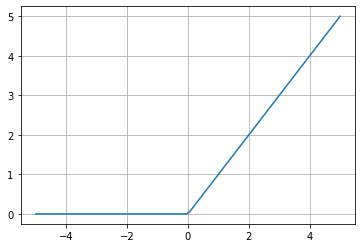

In [5]:
relu = lambda x: keras.activations.relu(x)
x = np.linspace(-5, 5, 100)
y = list(map(relu, x))

plt.plot(x, y)
plt.grid()

## Activations

`keras.activations` => Sigmoid, tanh, relu, elu, selu

음수일 때 무시되는 것을 해결하기 위한 leaky relu
`keras.layers`

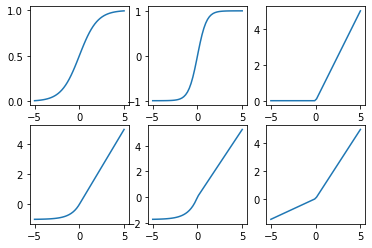

In [16]:
sigmoid = lambda x: keras.activations.sigmoid(x)
tanh = lambda x: keras.activations.tanh(x)
relu = lambda x: keras.activations.relu(x, alpha=0.0)
elu = lambda x: keras.activations.elu(x, alpha=1.0)
selu = lambda x: keras.activations.selu(x)
leaky_relu = lambda x: keras.layers.LeakyReLU(0.3)(x)

x = np.linspace(-5, 5, dtype=np.float32)

ax1 = plt.subplot(2, 3, 1)
ax1.plot(x, list(map(sigmoid, x)))

ax2 = plt.subplot(2, 3, 2)
ax2.plot(x, list(map(tanh, x)))

ax3 = plt.subplot(2, 3, 3)
ax3.plot(x, list(map(relu, x)))

ax4 = plt.subplot(2, 3, 4)
ax4.plot(x, list(map(elu, x)))

ax5 = plt.subplot(2, 3, 5)
ax5.plot(x, list(map(selu, x)))


ax6 = plt.subplot(2, 3, 6)
ax6.plot(x, list(map(leaky_relu, x)))

## With keras

In [17]:
normalize = lambda x, max: x.astype(np.float32) / max
normalize255 = lambda x: normalize(x, 255.0)

(train_data, train_labels), (test_data, test_labels) = keras.datasets.mnist.load_data()

train_data = np.expand_dims(train_data, -1)
test_data = np.expand_dims(test_data, -1)

train_data, test_data = map(normalize255, [train_data, test_data])

train_labels = tf.one_hot(train_labels, 10)
test_labels = tf.one_hot(test_labels, 10)

11493376/11490434 [==============================] - 0s 0us/step


In [29]:
class Model(keras.Model):
  def __init__(self, label_dim):
    super(Model, self).__init__()

    weight_init = keras.initializers.RandomNormal()
    self.model = keras.Sequential()

    self.model.add(keras.layers.Flatten())  # for fc

    for i in range(2):
      self.model.add(keras.layers.Dense(256, kernel_initializer=weight_init))
      self.model.add(keras.layers.Activation(keras.activations.relu))
    self.model.add(keras.layers.Dense(label_dim, kernel_initializer=weight_init))
  
  def call(self, x, training=None, mask=None):
    x = self.model(x)
    return x

In [21]:
def loss_fn(model, images, labels):
  logits = model(images, training=True)
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))

def accuracy_fn(model, images, labels):
  logits = model(images, training=False)
  prediction = tf.equal(tf.argmax(logits, -1), tf.argmax(labels, -1))
  accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
  return accuracy

def grad(model, images, labels):
  with tf.GradientTape() as tape:
    loss = loss_fn(model, images, labels)
  return tape.gradient(loss, model.variables)

In [22]:
lr = 0.001
batch_size = 128

training_epochs = 1
training_iterations = len(train_data)

label_dim = 10

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=batch_size).\
    batch(batch_size).\
    repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=batch_size).\
    batch(batch_size).\
    repeat()

In [30]:
network = Model(label_dim)
optimizer = keras.optimizers.Adam(lr)

In [32]:
checkpoint = tf.train.Checkpoint(dnn=network)

망

# Weight Initialization

## Xavier(Glorot) Initialization
$$
분산 = \frac 2 {\text{channel_in} + \text{channel_out}}
$$

`keras.initializers.GlorotNormal`

## He Initialization
Relu에 최적화

`keras.initializers.HeNormal`

# Dropout

학습은 잘 됐는데, test 데이터로 evaulate를 진행하면 loss가 클 때
nn에서 사용

> 뉴런의 일부분만 사용하는 학습 방법

랜덤으로 노드를 끔

좀더 일반화 된 모델을 이끌 수 있음

`keras.layers.Dropout`

Test할 때는 끄지 않고 모두 사용

일반적으로 활성함수 레이어 뒤에 붙인다고 한다

# Batch Normalization

`keras.layers.BatchNormalization`

일반적으로 활성함수 앞에 쓴다.